久保拓弥『データ解析のための統計モデリング入門』をJuliaでやってみます。

* 久保さんの書籍ページ：http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html
* Amazon.co.jp：https://amzn.to/2Cg5vDJ

# 第6章 GLMの応用範囲を広げる ---ロジスティック回帰など---

ポアソン分布・対数リンク関数の組み合わせ以外も使ってみよう、の章。

## 6.1 さまざまな種類のデータで応用できるGLM（p.114）

表6.1に近いものが http://juliastats.github.io/GLM.jl/stable/manual/#Fitting-GLM-models-1 に載っている。

| 確率分布     | family指定           | 正準リンク関数 |
| ------------ | -------------------- | -----------------|
| [二項分布](https://ja.wikipedia.org/w/index.php?title=%E4%BA%8C%E9%A0%85%E5%88%86%E5%B8%83)     | `Binomial()`         | `LogitLink()`    |
| [ポアソン分布](https://ja.wikipedia.org/wiki/%E3%83%9D%E3%82%A2%E3%82%BD%E3%83%B3%E5%88%86%E5%B8%83) | `Poisson()`          | `LogLink()`      |
| [負の二項分布](https://ja.wikipedia.org/wiki/%E8%B2%A0%E3%81%AE%E4%BA%8C%E9%A0%85%E5%88%86%E5%B8%83) | `NegativeBinomial()` | `LogLink()`      |
| [ガンマ分布](https://ja.wikipedia.org/wiki/%E3%82%AC%E3%83%B3%E3%83%9E%E5%88%86%E5%B8%83)   | `Gamma ()`           | `InverseLink()`  |
| [正規分布](https://ja.wikipedia.org/wiki/%E6%AD%A3%E8%A6%8F%E5%88%86%E5%B8%83)     | `Normal()`           | `IdentityLink()` |

Distributions.jlが入れてあれば、

* 確率密度関数は`pdf(Normal(mu, sigma), x)`
* 累積分布関数は`cdf(Normal(mu, sigma), x)`
* 乱数生成は`rand(Normal(mu, sigma), n)`

のように使える。

In [11]:
using DataFrames
using CSV
using Distributions
using GLM
using Plots
pyplot();
using StatsPlots

## 6.2 例題：上限のあるカウントデータ（p.115）

In [12]:
d = CSV.read("data4a.csv")
describe(d)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Int64,DataType
1,N,8.0,8,8.0,8,,0,Int64
2,y,5.08,0,6.0,8,,0,Int64
3,x,9.9672,7.66,9.965,12.44,,0,Float64
4,f,,C,,T,2,0,String


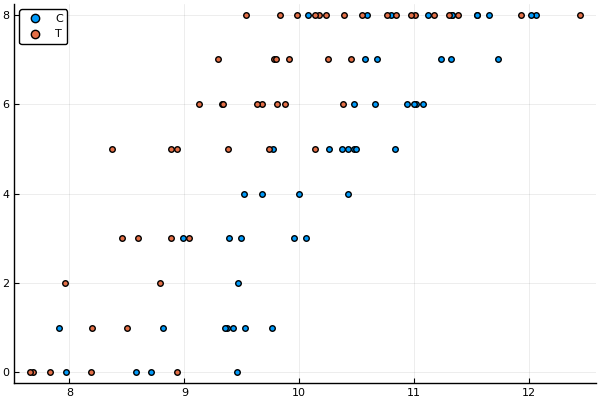

In [13]:
@df d scatter(:x, :y, group=:f)

## 6.3 二項分布で表現する「あり・なし」カウントデータ（p.118）

$$ p\left(y | N, q\right) = \binom{N}{y} q^y \left(1-q\right)^{N-y} $$

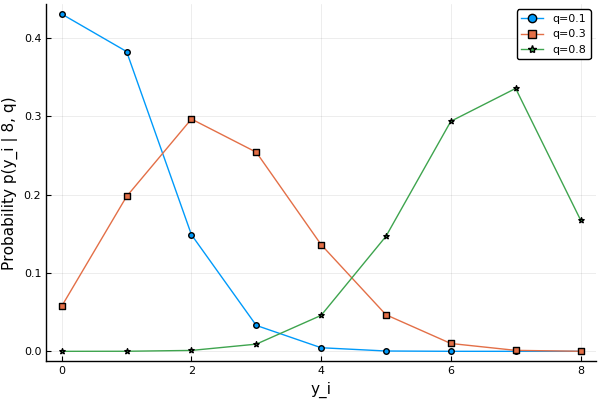

In [14]:
y = 0:8
plot(y, pdf.(Binomial(8, 0.1), y), marker=:auto, label="q=0.1", xlabel="y_i", ylabel="Probability p(y_i | 8, q)")
plot!(y, pdf.(Binomial(8, 0.3), y), marker=:auto, label="q=0.3")
plot!(y, pdf.(Binomial(8, 0.8), y), marker=:auto, label="q=0.8")

## 6.4 ロジスティック回帰とロジットリンク関数

### 6.4.1 ロジットリンク関数（p.119）

**ロジスティック関数**（_logistic function_）
$$ q_i = \mathrm{logistic}\left(z_i\right) = \frac{1}{1 + \exp\left(-z_i\right)} $$
$$ z_i = \beta_1 + \beta_2 x_i + \cdots $$

線形予測子の部分の定義が、本とDistribution.jlの`Logistic()`とで違うっぽいのでどうしようかなぁ、というところ。下のものが[Wikipedia](http://en.wikipedia.org/wiki/Logistic_distribution)に載っていた式。

$$f\left(x; \mu, \theta\right) = \frac{1}{1 + \exp\left(-\frac{x-\mu}{\theta}\right)}$$

$\exp$の中は$-z_i = -\frac{x-\mu}{\theta}$つまり$\beta_1 + \beta_2 x_i = \frac{1}{\theta}x_i - \frac{\mu}{\theta}$なので、$\beta_1 = -\frac{\mu}{\theta}$, $\beta_2 = \frac{1}{\theta}$でいいのかな。つまり$\mu = -\beta_1\theta$, $\theta = \frac{1}{\beta_2}$？

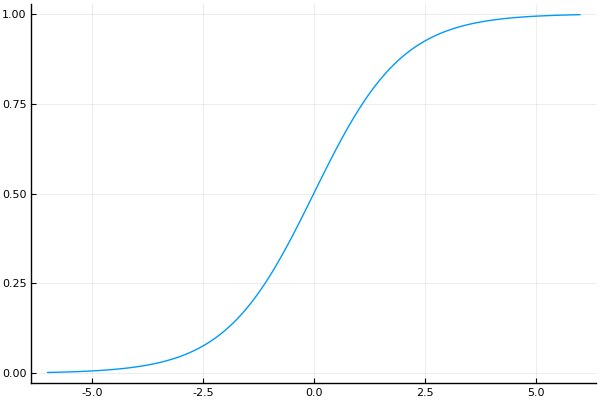

In [15]:
z = range(-6, stop=6, step=0.1)
b1 = 0; b2 = 1;
theta = 1 / b2
mu = -b1 * theta
plot(z, cdf.(Logistic(mu, theta), z), legend=false)

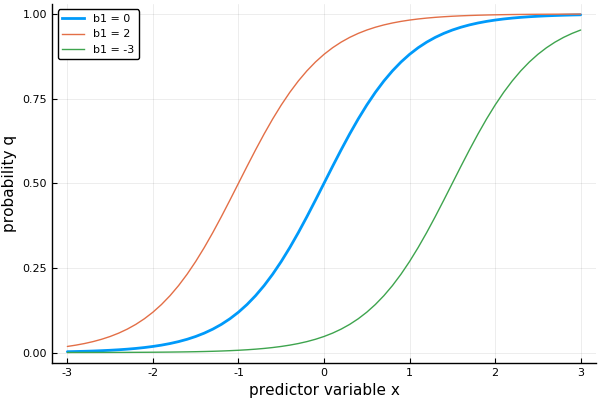

In [16]:
z = range(-3, stop=3, step=0.1)

b1 = 0; b2 = 2;
theta = 1 / b2
mu = -b1 * theta
plot(z, cdf.(Logistic(mu, theta), z), linewidth=2, xlabel="predictor variable x", ylabel="probability q", label="b1 = 0")

b1 = 2; b2 = 2;
theta = 1 / b2
mu = -b1 * theta
plot!(z, cdf.(Logistic(mu, theta), z), label="b1 = 2")

b1 = -3; b2 = 2;
theta = 1 / b2
mu = -b1 * theta
plot!(z, cdf.(Logistic(mu, theta), z), label="b1 = -3")

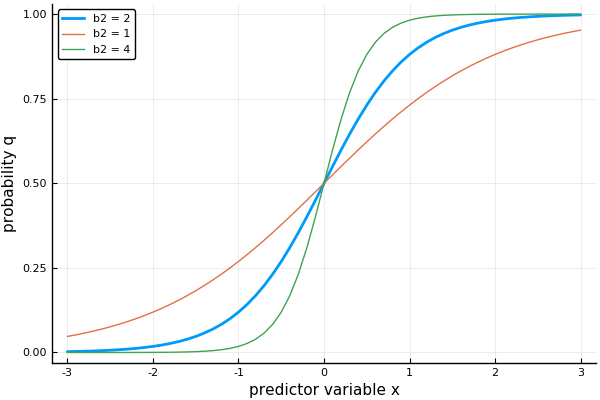

In [17]:
z = range(-3, stop=3, step=0.1)

b1 = 0; b2 = 2;
theta = 1 / b2
mu = -b1 * theta
plot(z, cdf.(Logistic(mu, theta), z), xlabel="predictor variable x", ylabel="probability q", label="b2 = 2", linewidth=2)

b1 = 0; b2 = 1;   # 負値が扱えない
theta = 1 / b2
mu = -b1 * theta
plot!(z, cdf.(Logistic(mu, theta), z), label="b2 = 1")

b1 = 0; b2 = 4;
theta = 1 / b2
mu = -b1 * theta
plot!(z, cdf.(Logistic(mu, theta), z), label="b2 = 4")

$\theta$を負値にすることができないけれど、βの値によって動くのは確認できた。p.121のグラフとも合致するのでOKぽい。

**ロジット関数**（_logit function_）はロジスティック関数の逆関数
$$ \log\frac{q_i}{1 - q_i} = z_i $$
$$ \mathrm{logit}\left(q_i\right) = \log\frac{q_i}{1 - q_i} $$

### 6.4.2 パラメータ推定（p.122）

尤度関数：
$$ L\left(\left\{\beta_j\right\}\right) = \prod_i \binom{N_i}{y_i} q^{y_i} \left(1-q\right)^{N_i-y_i} $$

対数尤度関数：
$$ \log L\left(\left\{\beta_j\right\}\right) = \sum_i\left\{\log\binom{N_i}{y_i} + y_i\log\left(q_i\right) + \left(N_i-y_i\right) \log\left(1-q\right) \right\}$$

Rのglmだと成功・失敗の二つの値を渡すために`cbind(y, N-y)`とやっているけど、GLM.jlだと成功比率を渡すっぽいので`y_ratio`を計算して使っている。

In [18]:
d[:y_ratio] = d[:y] ./ d[:N]
fit3 = glm(@formula(y_ratio ~ x + f), d, Binomial(8), LogitLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y_ratio ~ 1 + x + f

Coefficients:
             Estimate Std.Error  z value Pr(>|z|)
(Intercept)  -19.5361   3.99861 -4.88572    <1e-5
x             1.95241  0.392777  4.97077    <1e-6
f: T          2.02151  0.654152  3.09027   0.0020


ちょっといいかげんだけど、グラフも作ってみた。

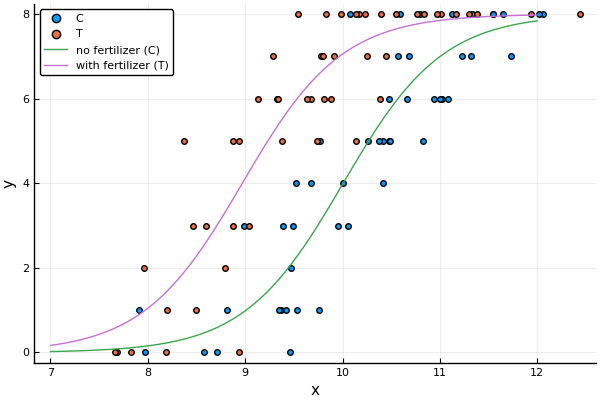

In [19]:
z = range(7, stop=12, length=101)
b1 = -19.5361; b2 = 1.95241; b3=2.02151;

theta = 1 / b2
mu = -b1 * theta
@df d scatter(:x, :y, group=:f, xlabel="x", ylabel="y", legend=:topleft)
plot!(z, cdf.(Logistic(mu, theta), z) * 8, label="no fertilizer (C)")

theta = 1 / b2
mu = -(b1 + b3) * theta
plot!(z, cdf.(Logistic(mu, theta), z) * 8, label="with fertilizer (T)")